In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from string import punctuation
import multiprocessing
from timeit import default_timer as timer
from sklearn.feature_extraction.text import TfidfVectorizer

# Data

In [2]:
all_data = pd.read_csv('complaints.csv').dropna(subset=['Consumer complaint narrative'])
all_data.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392.0
2,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198.0
3,2019-09-15,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,Pioneer has committed several federal violatio...,NaN,Pioneer Capital Solutions Inc,CA,925XX,NaN,Consent provided,Web,2019-09-15,Closed with explanation,Yes,NaN,3374555.0
4,2019-07-18,Mortgage,Conventional home mortgage,Closing on a mortgage,NaN,I started the process to refinance my current ...,Company has responded to the consumer and the ...,Freedom Mortgage Company,NC,275XX,NaN,Consent provided,Web,2019-07-18,Closed with explanation,Yes,NaN,3311105.0
6,2019-07-26,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,"Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/...",Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,914XX,NaN,Consent provided,Web,2019-07-26,Closed with explanation,Yes,NaN,3319331.0


In [3]:
all_data.Product.describe()

count                                                 14589
unique                                                   14
top       Credit reporting, credit repair services, or o...
freq                                                   6459
Name: Product, dtype: object

In [4]:
all_data['Consumer complaint narrative'][6]

'Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/XX/XXXX I requested that Experian send me a copy of the verifiable proof they have on file showing that the XXXX account they have listed on my credit report is actually mine. On XX/XX/XXXX and XX/XX/XXXX, instead of sending me a copy of the verifiable proof that I requested, Experian sent me a statement which reads, " The information you disputed has been verified as accurate. \'\' Experian also failed to provide me with the method of " verification. \'\' Since Experian neither provided me with a copy of the verifiable proof, nor did they delete the unverified information, I believe they are in violation of the Fair Credit Reporting Act and I have been harmed as a result. I have again, today, sent my fourth and final written request that they verify the account, and send me verifiable proof that this account is mine, or that they delete the unverified account. If they do not, my next step is to pursue a remedy through litigation.'

# ZAD1
#### Proszę znaleźć i porównać przynajmniej 2 metody obliczania reprezentacji wektorowej tekstu na podstawie osadzeń słów. Proszę je przetestować na klasyfikacji wieloklasowej tekstu.

Wybrałem zbiór [*Consumer Complaint Database*](https://catalog.data.gov/dataset/consumer-complaint-database)
w którym dokonam klasyfikacji rodzaju produktu (Product) na podstawie skargi (Consumer complaint narrative) przy użyciu Doc2Vec w wersji DBOW (Distributed Bag Of Words) oras DM (Distributed Memory) i TF-IDF.


In [5]:
data = all_data[['Product', 'Consumer complaint narrative']]
data.rename(columns={'Consumer complaint narrative': 'Complaint'}, inplace=True)
data.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Product,Complaint
0,Debt collection,transworld systems inc. \nis trying to collect...
2,Debt collection,"Over the past 2 weeks, I have been receiving e..."
3,Debt collection,Pioneer has committed several federal violatio...
4,Mortgage,I started the process to refinance my current ...
6,"Credit reporting, credit repair services, or o...","Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/..."


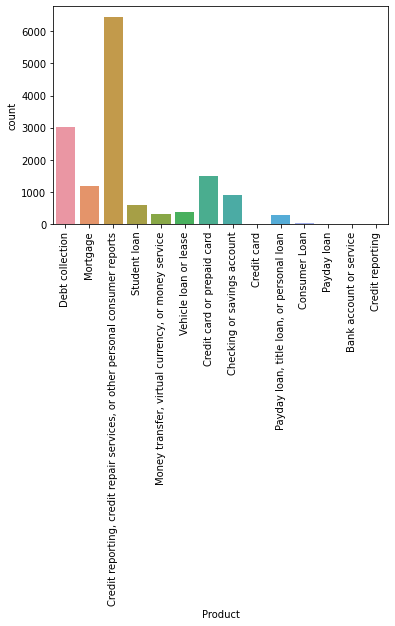

In [6]:
sns.countplot(x="Product", data=data)
plt.xticks(rotation=90)
plt.show()

In [7]:
tags = ['URL', 'DATE', 'CONF']
def preprocess_text(text):
    #clean URL
    text = re.sub(r'http/S+', r'URL', text)
    #clean date
    text = re.sub(r'(XX/XX/XXXX)|(XX/XX/\d\d\d\d)', r'DATE', text)
    #delete \n
    text = re.sub(r'\n', r' ', text)
    #some confidential data
    text = re.sub(r'XXXX', r'CONF', text)
    return text

data.Complaint = data.Complaint.apply(preprocess_text)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [8]:
data.Complaint[6]

'Previously, on DATE, DATE, and DATE I requested that Experian send me a copy of the verifiable proof they have on file showing that the CONF account they have listed on my credit report is actually mine. On DATE and DATE, instead of sending me a copy of the verifiable proof that I requested, Experian sent me a statement which reads, " The information you disputed has been verified as accurate. \'\' Experian also failed to provide me with the method of " verification. \'\' Since Experian neither provided me with a copy of the verifiable proof, nor did they delete the unverified information, I believe they are in violation of the Fair Credit Reporting Act and I have been harmed as a result. I have again, today, sent my fourth and final written request that they verify the account, and send me verifiable proof that this account is mine, or that they delete the unverified account. If they do not, my next step is to pursue a remedy through litigation.'

In [9]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
stopwords_en = stopwords.words('english')

def tag_text(text):
    tags = []
    for sentence in sent_tokenize(text):
        for word in word_tokenize(sentence):
            word = word.lower()
            if word not in tags and word not in stopwords_en and word.isalpha():
                tags.append(word.lower())            
    return tags

data.Complaint = data.Complaint.apply(tag_text)

In [11]:
data.Complaint[6]

['previously',
 'date',
 'requested',
 'experian',
 'send',
 'copy',
 'verifiable',
 'proof',
 'file',
 'showing',
 'conf',
 'account',
 'listed',
 'credit',
 'report',
 'actually',
 'mine',
 'instead',
 'sending',
 'sent',
 'statement',
 'reads',
 'information',
 'disputed',
 'verified',
 'accurate',
 'also',
 'failed',
 'provide',
 'method',
 'verification',
 'since',
 'neither',
 'provided',
 'delete',
 'unverified',
 'believe',
 'violation',
 'fair',
 'reporting',
 'act',
 'harmed',
 'result',
 'today',
 'fourth',
 'final',
 'written',
 'request',
 'verify',
 'next',
 'step',
 'pursue',
 'remedy',
 'litigation']

## Doc2Vec

In [12]:
train, test = train_test_split(data, test_size=0.3)
d2v_train = train.apply(lambda x: TaggedDocument(words=x.Complaint, tags=x.Product), axis=1)
d2v_test = test.apply(lambda x: TaggedDocument(words=x.Complaint, tags=x.Product), axis=1)

### DBOW

In [13]:
def train_DBOW():
    cores = multiprocessing.cpu_count()
    MAX_EPOCHS = 25

    dbow_100 = Doc2Vec(dm=0, vector_size=100, negative=5, hs=0, min_count=2, window=10, workers=cores, dbow_words=1, batch_words=1000)
    dbow_100.build_vocab(d2v_train.values)
    
    total_exaples = len(d2v_train.values)
    for epoch in range(MAX_EPOCHS):
        print(f'Epoch {epoch} starting')
        start = timer()

        dbow_100.train(d2v_train.values, total_examples=total_exaples, epochs=1)
        dbow_100.alpha -= 0.004
        dbow_100.min_alpha = dbow_100.alpha

        end = timer()
        print(f'Finished in {end-start}s')
    # dbow_100.save('dbow100.model')
    return dbow_100
        
dbow_100 = train_DBOW()
# dbow_100 = Doc2Vec.load('dbow100.model')
    

Epoch 0 starting
Finished in 28.52119633799998s
Epoch 1 starting
Finished in 29.063898006000045s
Epoch 2 starting
Finished in 28.259575826999935s
Epoch 3 starting
Finished in 28.386629240000048s
Epoch 4 starting
Finished in 28.339179666000064s
Epoch 5 starting
Finished in 28.6423530080001s
Epoch 6 starting
Finished in 28.657321784000032s
Epoch 7 starting
Finished in 20.38449155699982s
Epoch 8 starting
Finished in 19.677702604999922s
Epoch 9 starting
Finished in 19.664583013999845s
Epoch 10 starting
Finished in 19.631667618999927s
Epoch 11 starting
Finished in 19.46786191399997s
Epoch 12 starting
Finished in 19.52342912800009s
Epoch 13 starting
Finished in 19.549199213999827s
Epoch 14 starting
Finished in 19.57481117899988s
Epoch 15 starting
Finished in 19.452914362s
Epoch 16 starting
Finished in 19.399128022000014s
Epoch 17 starting
Finished in 19.2199850909999s
Epoch 18 starting
Finished in 19.26986765300012s
Epoch 19 starting
Finished in 19.30290532700019s
Epoch 20 starting
Finished 

In [14]:
def get_vector_data(data, model):
    X = []
    y = []
    for complaint, product in data:
        y.append(product)
        X.append(model.infer_vector(complaint))
    return X, y
        

In [15]:
X_dbow_train_vec, y_dbow_train_vec = get_vector_data(d2v_train, dbow_100)
X_dbow_test_vec, y_dbow_test_vec = get_vector_data(d2v_test, dbow_100)

### DM

In [16]:
def train_DM():
    cores = multiprocessing.cpu_count()
    MAX_EPOCHS = 25

    dm_100 = Doc2Vec(dm=1, vector_size=100, negative=5, hs=0, min_count=2, window=10, workers=cores, batch_words=1000)
    dm_100.build_vocab(d2v_train.values)
    
    total_exaples = len(d2v_train.values)
    for epoch in range(MAX_EPOCHS):
        print(f'Epoch {epoch} starting')
        start = timer()

        dm_100.train(d2v_train.values, total_examples=total_exaples, epochs=1)
        dm_100.alpha -= 0.004
        dm_100.min_alpha = dm_100.alpha

        end = timer()
        print(f'Finished in {end-start}s')
    # dm_100.save('dm_100.model')
    return dm_100
        
dm_100 = train_DM()
# dm_100 = Doc2Vec.load('dm_100.model')
    

Epoch 0 starting
Finished in 3.73783436299982s
Epoch 1 starting
Finished in 3.724918652000042s
Epoch 2 starting
Finished in 3.545465529000012s
Epoch 3 starting
Finished in 3.634766620000164s
Epoch 4 starting
Finished in 3.591143310999996s
Epoch 5 starting
Finished in 3.6143050499999845s
Epoch 6 starting
Finished in 3.6099548299998787s
Epoch 7 starting
Finished in 3.417164059000015s
Epoch 8 starting
Finished in 3.4111905229999593s
Epoch 9 starting
Finished in 3.483519648000083s
Epoch 10 starting
Finished in 3.46317590700005s
Epoch 11 starting
Finished in 3.4044024389997958s
Epoch 12 starting
Finished in 3.4849180490000435s
Epoch 13 starting
Finished in 3.4739677500001562s
Epoch 14 starting
Finished in 3.4137544540001272s
Epoch 15 starting
Finished in 3.462127920000057s
Epoch 16 starting
Finished in 3.4263714260000597s
Epoch 17 starting
Finished in 3.429454283000041s
Epoch 18 starting
Finished in 3.481087910000042s
Epoch 19 starting
Finished in 3.418659286999855s
Epoch 20 starting
Finish

In [23]:
X_dm_train_vec, y_dm_train_vec = get_vector_data(d2v_train, dm_100)
X_dm_test_vec, y_dm_test_vec = get_vector_data(d2v_test, dm_100)

## TF-IDF

In [17]:
tfidf_vectorizer = TfidfVectorizer()
X_train = [" ".join(complaint) for prod, complaint in train.values]
y_train = [prod for prod, complaint in train.values]

X_test = [" ".join(complaint) for prod, complaint in test.values]
y_test = [prod for prod, complaint in test.values]

In [18]:
X_tfidf_train = tfidf_vectorizer.fit_transform(X_train)

In [19]:
X_tfidf_test = tfidf_vectorizer.transform(X_test)

# Klasyfikacja

In [21]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [22]:
GNB_dbow_clf = GaussianNB()
KNN_dbow_clf = KNeighborsClassifier(n_neighbors = 7, n_jobs=-1)
LR_dbow_clf = LogisticRegression(n_jobs=-1)
RF_dbow_clf = RandomForestClassifier(n_jobs=-1)

GNB_dm_clf = GaussianNB()
KNN_dm_clf = KNeighborsClassifier(n_neighbors = 7, n_jobs=-1)
LR_dm_clf = LogisticRegression(n_jobs=-1)
RF_dm_clf = RandomForestClassifier(n_jobs=-1)

GNB_tfidf_clf = GaussianNB()
KNN_tfidf_clf = KNeighborsClassifier(n_neighbors = 7)
LR_tfidf_clf = LogisticRegression(n_jobs=-1)
RF_tfidf_clf = RandomForestClassifier(n_jobs=-1)


In [25]:
GNB_dbow_clf.fit(X_dbow_train_vec, y_dbow_train_vec)

GaussianNB(priors=None, var_smoothing=1e-09)

In [26]:
KNN_dbow_clf.fit(X_dbow_train_vec, y_dbow_train_vec)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=7, p=2,
                     weights='uniform')

In [27]:
LR_dbow_clf.fit(X_dbow_train_vec, y_dbow_train_vec)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
RF_dbow_clf.fit(X_dbow_train_vec, y_dbow_train_vec)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [28]:
GNB_dm_clf.fit(X_dm_train_vec, y_dm_train_vec)

GaussianNB(priors=None, var_smoothing=1e-09)

In [29]:
KNN_dm_clf.fit(X_dm_train_vec, y_dm_train_vec)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=7, p=2,
                     weights='uniform')

In [30]:
LR_dm_clf.fit(X_dm_train_vec, y_dm_train_vec)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
RF_dm_clf.fit(X_dm_train_vec, y_dm_train_vec)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [32]:
GNB_tfidf_clf.fit(X_tfidf_train.toarray(), y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [33]:
KNN_tfidf_clf.fit(X_tfidf_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [34]:
LR_tfidf_clf.fit(X_tfidf_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
RF_tfidf_clf.fit(X_tfidf_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

## Wyniki

In [40]:
print(f"""
Doc2Vec:
    DBOW:
        GaussianNB:
            acc: {GNB_dbow_clf.score(X_dbow_test_vec, y_dbow_test_vec)}
        KNN:
            acc: {KNN_dbow_clf.score(X_dbow_test_vec, y_dbow_test_vec)}
        Logistic Regression:
            acc: {LR_dbow_clf.score(X_dbow_test_vec, y_dbow_test_vec)}
        Random Forest:
            acc: {RF_dbow_clf.score(X_dbow_test_vec, y_dbow_test_vec)}
    DM:
        GaussianNB:
            acc: {GNB_dm_clf.score(X_dm_test_vec, y_dm_test_vec)}
        KNN:
            acc: {KNN_dm_clf.score(X_dm_test_vec, y_dm_test_vec)}
        Logistic Regression:
            acc: {LR_dm_clf.score(X_dm_test_vec, y_dm_test_vec)}
        Random Forest:
            acc: {RF_dm_clf.score(X_dm_test_vec, y_dm_test_vec)}
      
---------------------------------------------

TF-IDF
    GaussianNB:
        acc: {GNB_tfidf_clf.score(X_tfidf_test.toarray(), y_test)}
    KNN:
        acc: {KNN_tfidf_clf.score(X_tfidf_test, y_test)}
    Logistic Regression:
        acc: {LR_tfidf_clf.score(X_tfidf_test, y_test)}
    Random Forest:
        acc: {RF_tfidf_clf.score(X_tfidf_test, y_test)}
                            
""")


Doc2Vec:
    DBOW:
        GaussianNB:
            acc: 0.3557230980123372
        KNN:
            acc: 0.3904500799634453
        Logistic Regression:
            acc: 0.44528215672835275
        Random Forest:
            acc: 0.44459675576879143
    DM:
        GaussianNB:
            acc: 0.10875028558373315
        KNN:
            acc: 0.6287411469042723
        Logistic Regression:
            acc: 0.6557002513136851
        Random Forest:
            acc: 0.6659812657071054
      
---------------------------------------------

TF-IDF
    GaussianNB:
        acc: 0.32876399360292435
    KNN:
        acc: 0.6186885994973726
    Logistic Regression:
        acc: 0.8078592643363034
    Random Forest:
        acc: 0.752570253598355
                            



Zastosowałem dwa warianty Doc2Vec, które dały bardzo odmienne wyniki:
* **DM (Distributed Memory)** w celu utworzenia wektora dla dokumentu (skargi) stara się przewidzieć losowe słowo z niego na podstawie kontekstu oraz identyfikatora dokumentu.
* **DBOW (Distributed Bag Of Words)** nie używa kontekstu w celu utworzenia wektora dla danego dokumentu, a jedynie na podstawie jego identyfikatora stara się przewidzieć kilka wybranych słów z tego dokumentu.

Dla wszystkich klasyfikatorów (poza GaussianNB) DM okazał się znacząco lepszy, bo aż o około 20 punktów procentowych.



# Zadanie 2
#### Proszę wykonać klasteryzację załączonych adresów przy pomocy przynajmniej 3 metryk w przestrzeni napisów (np. LCS, Levenshteina, DICE) i porównać wyniki.

In [ ]:
!pip3 install scikit-learn-extra
!pip3 install leven
!pip3 install distance-metrics
!pip3 install Distance
!pip3 install textdistance

In [42]:
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import dbscan
from leven import levenshtein 
from distance_metrics import lcs
# from scipy.spatial.distance import dice
from distance import jaccard, sorensen
from functools import partial
import matplotlib.pyplot as plt
import random
from textdistance import lcsseq, sorensen_dice

In [43]:
def get_comps_by_index(comp1_ind, comp2_ind):
    comp1_ind = int(comp1_ind)
    comp2_ind = int(comp2_ind)

    comp1 = KMed_X_data[comp1_ind]
    comp2 = KMed_X_data[comp2_ind]
    return comp1, comp2

def lev_metric(comp1_ind, comp2_ind):
    comp1, comp2 = get_comps_by_index(comp1_ind, comp2_ind)
    return levenshtein(comp1, comp2)

# Liczyła się zbyt długo i z niej zrezygnowałem
def lcs_metric(comp1_ind, comp2_ind):
    comp1, comp2 = get_comps_by_index(comp1_ind, comp2_ind)
    dist = lcs.llcs(comp1, comp2)
    if dist > 0:
        return 1/dist
    else:
        return np.inf

# Liczyła się zbyt długo i z niej zrezygnowałem
def bakkelund_metric(comp1_ind, comp2_ind):
    comp1, comp2 = get_comps_by_index(comp1_ind, comp2_ind)
    return lcs.bakkelund(comp1, comp2)


def jaccard_metric(comp1_ind, comp2_ind):
    comp1, comp2 = get_comps_by_index(comp1_ind, comp2_ind)
    return jaccard(comp1, comp2)


def sorensen_metric(comp1_ind, comp2_ind):
    comp1, comp2 = get_comps_by_index(comp1_ind, comp2_ind)
    return sorensen(comp1, comp2)


def sorensen_dice_metric(comp1_ind, comp2_ind):
    comp1, comp2 = get_comps_by_index(comp1_ind, comp2_ind)
    return sorensen_dice(comp1, comp2)


def precompute_distances(metric):
    num_of_comp = KMed_X_data.shape[0]
    precomputed_distances = np.zeros((num_of_comp, num_of_comp))
    for comp1_ind in range(num_of_comp):
        for comp2_ind in range(comp1_ind, num_of_comp):
            if comp1_ind != comp2_ind:
                dist = metric(comp1_ind, comp2_ind)
                precomputed_distances[comp1_ind, comp2_ind] = dist
    return precomputed_distances
                
def precomputed_metric(precomputed_distances, comp1_ind, comp2_ind):
    comp1_ind = int(comp1_ind)
    comp2_ind = int(comp2_ind)
    if comp1_ind < comp2_ind:
        return precomputed_distances[comp1_ind, comp2_ind]
    else:
        return precomputed_distances[comp2_ind, comp1_ind]


In [44]:
N_CLUSTERS = len(data.Product.unique())

train_size, test_size = 400, 100      #ze wzeględu na bardzo długi czas obliczania odległości
KMed_X_data = np.hstack([X_train[:train_size], X_test[:test_size]])
KMed_y_data = np.hstack([y_train[:train_size], y_test[:test_size]])

KMed_X_train = np.arange(len(X_train[:train_size])).reshape(-1, 1)
KMed_X_test = np.arange(len(X_test[:test_size])).reshape(-1, 1)

KMed_y_test = y_test[:test_size]

In [45]:
precomputed_lev = partial(precomputed_metric, precompute_distances(lev_metric))
KMed_lev = KMedoids(n_clusters=N_CLUSTERS, metric=precomputed_lev)

In [46]:
KMed_lev.fit(KMed_X_train)

KMedoids(init='heuristic', max_iter=300,
         metric=functools.partial(<function precomputed_metric at 0x7f4c2ab33b70>, array([[  0., 264., 817., ..., 245., 738., 241.],
       [  0.,   0., 803., ..., 260., 728., 277.],
       [  0.,   0.,   0., ..., 833., 780., 914.],
       ...,
       [  0.,   0.,   0., ...,   0., 758., 227.],
       [  0.,   0.,   0., ...,   0.,   0., 828.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])),
         n_clusters=14, random_state=None)

In [47]:
precomputed_jac = partial(precomputed_metric, precompute_distances(jaccard_metric))
KMed_jac = KMedoids(n_clusters=N_CLUSTERS, metric=precomputed_jac)

In [48]:
KMed_jac.fit(KMed_X_train)

/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  "its corresponding cluster ({k}).".format(k=k)
/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  "its corresponding cluster ({k}).".format(k=k)
/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  "its corresponding cluster ({k}).".format(k=k)
/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  "its corresponding cluster 

KMedoids(init='heuristic', max_iter=300,
         metric=functools.partial(<function precomputed_metric at 0x7f4c2ab33b70>, array([[0.        , 0.07692308, 0.07407407, ..., 0.11538462, 0.14814815,
        0.11538462],
       [0.        , 0.        , 0.14814815, ..., 0.04166667, 0.08      ,
        0.04166667],
       [0.        , 0.        , 0.        , ..., 0.11538462, 0.07692308,
        0.11538462],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.04166667,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.04166667],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])),
         n_clusters=14, random_state=None)

In [49]:
precomputed_sor = partial(precomputed_metric, precompute_distances(sorensen_metric))
KMed_sor = KMedoids(n_clusters=N_CLUSTERS, metric=precomputed_sor)

In [50]:
KMed_sor.fit(KMed_X_train)

/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  "its corresponding cluster ({k}).".format(k=k)
/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  "its corresponding cluster ({k}).".format(k=k)
/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  "its corresponding cluster ({k}).".format(k=k)
/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  "its corresponding cluster 

KMedoids(init='heuristic', max_iter=300,
         metric=functools.partial(<function precomputed_metric at 0x7f4c2ab33b70>, array([[0.        , 0.04      , 0.03846154, ..., 0.06122449, 0.08      ,
        0.06122449],
       [0.        , 0.        , 0.08      , ..., 0.0212766 , 0.04166667,
        0.0212766 ],
       [0.        , 0.        , 0.        , ..., 0.06122449, 0.04      ,
        0.06122449],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.0212766 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0212766 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])),
         n_clusters=14, random_state=None)

In [51]:
precomputed_s_dice = partial(precomputed_metric, precompute_distances(sorensen_dice_metric))
KMed_s_dice = KMedoids(n_clusters=N_CLUSTERS, metric=precomputed_s_dice)

In [52]:
KMed_s_dice.fit(KMed_X_train)

KMedoids(init='heuristic', max_iter=300,
         metric=functools.partial(<function precomputed_metric at 0x7f4c2ab33b70>, array([[0.        , 0.8588064 , 0.47050147, ..., 0.8704    , 0.5023622 ,
        0.59354839],
       [0.        , 0.        , 0.51036455, ..., 0.81137725, 0.55293222,
        0.55905512],
       [0.        , 0.        , 0.        , ..., 0.44427823, 0.89404642,
        0.24299065],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.48441247,
        0.6367713 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.26214482],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])),
         n_clusters=14, random_state=None)

In [53]:
#precomputed_lcs = partial(precomputed_metric, precompute_distances(lcs_metric))
#KMed_lcs = KMedoids(n_clusters=N_CLUSTERS, metric=precomputed_lcs)

In [54]:
# KMed_lcs.fit(KMed_X_train)

In [55]:
# precomputed_bak = partial(precomputed_metric, precompute_distances(bakkelund_metric))
# KMed_bak = KMedoids(n_clusters=N_CLUSTERS, metric=precomputed_bak)

In [56]:
# KMed_bak.fit(KMed_X_train)

In [87]:
def print_cluster(true_labels, predictions, data, name):
    clusters = dict()
    for i, pred in enumerate(predictions):
        if pred not in clusters.keys():
            clusters[pred] = []
        clusters[pred].append((true_labels[i], KMed_X_data[data[i]][0]))
    
    print(name)
    for cluster, lc in clusters.items():
        print(f"  Cluster nr: {cluster}")
        cluster_prod_freq = dict()
        prod_comps = dict()
        for label, complaint in lc:
            cluster_prod_freq[label] = cluster_prod_freq.get(label, 0) + 1
            if label not in prod_comps.keys():
                prod_comps[label] = []
            prod_comps[label].append(complaint)

        cluster_prod_freq = {k: v for k, v in sorted(cluster_prod_freq.items(), key=lambda item: -item[1])}
        for prod, freq in cluster_prod_freq.items():
            print(f'\t{freq}: {prod}')
            for comp in prod_comps[prod]:
                print(f'\t\t-{comp}')



In [88]:
lev_pred = KMed_lev.predict(KMed_X_test)
print_cluster(KMed_y_test, lev_pred, KMed_X_test, 'LEVENSHTEIN')

LEVENSHTEIN
  Cluster nr: 1
	2: Credit reporting, credit repair services, or other personal consumer reports
		-contract date year conf term apr payment amount financed original finance charge note problem follows made large four times asked pay extra money towards principal never done adjust refused see states per cent annually however found also day equals top interest predatory loan stated car asking credited account taken life
		-account american express credit cards months line since opening balance payments exceeded minimum monthly payment due paid prior date late ever received email informing lowered reason replied feedback link sent wanted explained completely uncalled unfair business practice additionally asked file appeal process works response would like looked please never missed accounts
	1: Mortgage
		-tired many problems bank closed account dont pay lawyer divorce impossible complaint ex husband file contacts conf called received check since almost months apartament unfo

In [90]:
jac_pred = KMed_jac.predict(KMed_X_test)
print_cluster(KMed_y_test, jac_pred, KMed_X_test,'JACCARD')

JACCARD
  Cluster nr: 0
	47: Credit reporting, credit repair services, or other personal consumer reports
		-contract date year conf term apr payment amount financed original finance charge note problem follows made large four times asked pay extra money towards principal never done adjust refused see states per cent annually however found also day equals top interest predatory loan stated car asking credited account taken life
		-took loan conf understand terms since documents give dont read write told said juat sigh moved hard time paying got better job refused take payments use inappropriate language talk inappropriately made lots attempts make guy actually sent small payment least would send back every try call someone else tell one believe attempt get money kept charging fees able pay
		-conf credit card account cc current financial hardship came date began working paid amounts enough income continue paying minimum due keep time debt incurred approximately give take dollars contac

In [91]:
sor_pred = KMed_sor.predict(KMed_X_test)
print_cluster(KMed_y_test, sor_pred, KMed_X_test,'SORENSEN')

SORENSEN
  Cluster nr: 0
	47: Credit reporting, credit repair services, or other personal consumer reports
		-contract date year conf term apr payment amount financed original finance charge note problem follows made large four times asked pay extra money towards principal never done adjust refused see states per cent annually however found also day equals top interest predatory loan stated car asking credited account taken life
		-took loan conf understand terms since documents give dont read write told said juat sigh moved hard time paying got better job refused take payments use inappropriate language talk inappropriately made lots attempts make guy actually sent small payment least would send back every try call someone else tell one believe attempt get money kept charging fees able pay
		-conf credit card account cc current financial hardship came date began working paid amounts enough income continue paying minimum due keep time debt incurred approximately give take dollars conta

In [92]:
s_dice_pred = KMed_s_dice.predict(KMed_X_test)
print_cluster(KMed_y_test, s_dice_pred, KMed_X_test,'SORENSEN - DICE')

SORENSEN - DICE
  Cluster nr: 4
	36: Credit reporting, credit repair services, or other personal consumer reports
		-contract date year conf term apr payment amount financed original finance charge note problem follows made large four times asked pay extra money towards principal never done adjust refused see states per cent annually however found also day equals top interest predatory loan stated car asking credited account taken life
		-took loan conf understand terms since documents give dont read write told said juat sigh moved hard time paying got better job refused take payments use inappropriate language talk inappropriately made lots attempts make guy actually sent small payment least would send back every try call someone else tell one believe attempt get money kept charging fees able pay
		-conf credit card account cc current financial hardship came date began working paid amounts enough income continue paying minimum due keep time debt incurred approximately give take dollar

# Wyniki

Z przetestowanych metryk najlepiej poradziła sobie metryka Levenshteina, starająć się chociaż utworzyć klastry opisujące skargi na różne produkty. Niestety dużą część w tym zbiorze zajmuje klasa *Credit reporting, credit repair services, or other personal consumer reports.* co powoduje duże zaburzenia i skargi tej klasy znajdują się w większośći klastrów. Można jednak zauważyć zależność pomiędzy *Debt collection* i *Mortgage*, które to często znajdują się w tym samym klastrze.

Następnie przetestowałem metryki Jaccarda i Sorensena, która w ogóle nie poradziły sobie z tym zadaniem i dystanse obliczone według nich za mało się różniły, co spowodowało utworzenie pojedynczych klastrów.

Sytuację tę zmieniło dopiero użycie wariantu Sorensen-DICE, użycie tej metryki spowodowało natomiast utworzenie 6 klastrów, z których 4 są bardzo małe, a dwa zawierają wiele klas. Tym razem jednak znowu możemy dostrzec, że *Debt collection* i *Mortgage* mają pewne podobieńśtwa, gdyż w pierwszym klastrze jest ich po 3, natomiast w drugim 11 i 8.

Po dodaniu wypisywania otagowanych treści skarg można dostrzec, że w pojedynczych lub posiadających mało członków klastrach znajdują się zazwyczaj bardzo krótkie skargi, co tłumaczy dlaczego ciężko było je przyłączyć do któregoś z większych klastrów, gdyż posiadały zbyt mało słów z nimi powiązanymi.